In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print(f"OpenCV version: {cv2.__version__}")

OpenCV version: 4.11.0


In [26]:
def make_extractor() -> cv2.Feature2D:
    """
    Prefer SIFT (robust for text/edges), fall back to ORB/AKAZE if SIFT not available
    """
    if hasattr(cv2, 'SIFT_create'):
        return cv2.SIFT_create(nfeatures=6000)
    if hasattr(cv2, 'AKAZE_create'):
        return cv2.AKAZE_create()
    return cv2.ORB_create(nfeatures=6000)

def is_float_desc(desc: np.ndarray) -> bool:
    return desc is not None and desc.dtype == np.float32

def imread(path: Path) -> np.ndarray:
    """
    Read an image from a file.
    Raises FileNotFoundError if the image cannot be read.
    """
    img = cv2.imread(str(path))
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

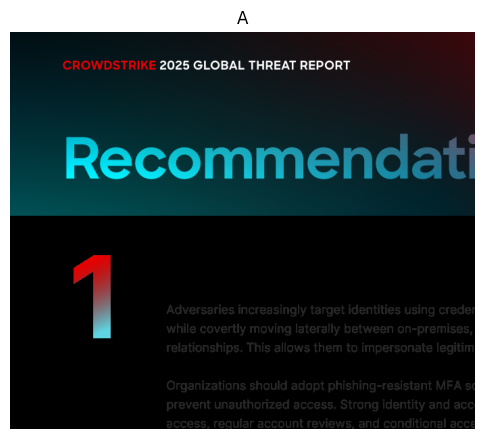

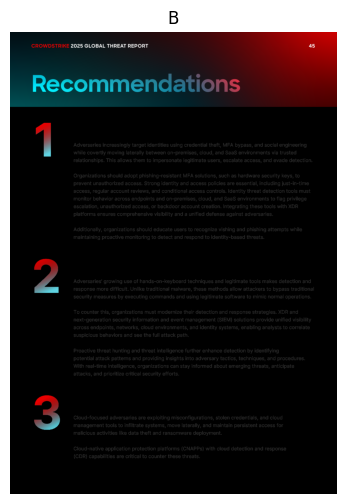

In [27]:
# NOTE: We don't know the relative pose between these two images
A_PATH = "./images/left_crop.png"
B_PATH = "./images/right_full.png"

A = imread(Path(A_PATH))
B = imread(Path(B_PATH))

def imshow(title: str, bgr: np.ndarray) -> None:
    """
    Show a BGR image using matplotlib (which expects RGB).
    """
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()


imshow("A", A)
imshow("B", B)

A: 1931 keypoints, desc shape: (1931, 128), float: True
B: 6007 keypoints, desc shape: (6007, 128), float: True


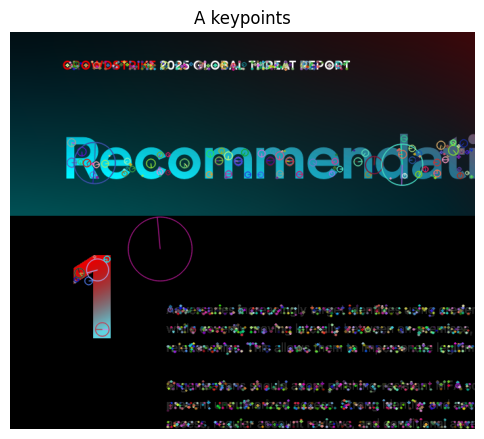

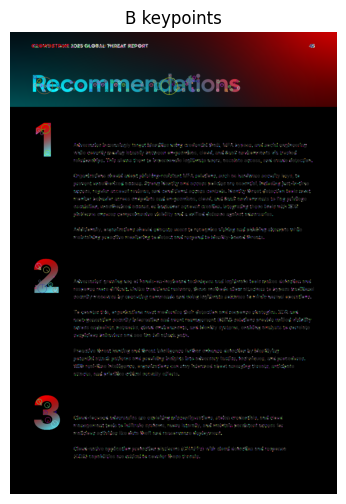

In [28]:
extractor = make_extractor()

def detect(gray: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Detect keypoints and compute descriptors.
    """
    keypoints, desc = extractor.detectAndCompute(gray, None)
    if desc is None or len(keypoints) < 10:
        raise ValueError("Not enough keypoints detected.")
    return keypoints, desc

A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

A_kp, A_desc = detect(A_gray)
B_kp, B_desc = detect(B_gray)

print(f"A: {len(A_kp)} keypoints, desc shape: {A_desc.shape}, float: {is_float_desc(A_desc)}")
print(f"B: {len(B_kp)} keypoints, desc shape: {B_desc.shape}, float: {is_float_desc(B_desc)}")

# Visual check!
# In the following code, we can draw keypoints of each image
A_vis = cv2.drawKeypoints(A, A_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
B_vis = cv2.drawKeypoints(B, B_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow("A keypoints", A_vis)
imshow("B keypoints", B_vis)    

In [29]:
def match_descriptors(q_desc: np.ndarray, s_desc: np.ndarray) -> list[list[cv2.DMatch]]:
    """
    Return list of [m, n] pairs, where m is the best match and n is the second best match,
    from knnMatch(k=2), or empty list if no matches found.
    """
    if q_desc is None or s_desc is None:
        return []
    # Use a brute-force matcher with appropriate norm
    matcher = cv2.BFMatcher(cv2.NORM_L2 if is_float_desc(q_desc) else cv2.NORM_HAMMING)
    raw_matches = matcher.knnMatch(q_desc, s_desc, k=2)
    return [pair for pair in raw_matches if len(pair) == 2]

# Example: matches for A -> B (query A, scene B)
raw_matches_AB = match_descriptors(A_desc, B_desc)
print(f"Found {len(raw_matches_AB)} raw matches between A and B")

Found 1931 raw matches between A and B


In [30]:
def _quad_is_sane(quad: np.ndarray, scene_shape: tuple[int, int, int]) -> bool:
    """
    Check if the projected quadrilateral is sane:
    - Not None
    - Area > 0 and not too small
    - At least 3 points within scene bounds
    """
    if quad is None:
        return False
    
    points = quad.reshape(-1, 2).astype(np.float32)
    # Area > 0 and convex:
    area = cv2.contourArea(points)
    if area < 64:
        # Too small area
        return False
    Hs, Ws = scene_shape[:2]
    in_bounds = sum(0 <= x <= Ws and 0 <= y <= Hs for x, y in points)
    return in_bounds >= 3  # At least 3 points in bounds

### RANSAC homography + diagnostics

In [31]:
def project_corners(q_img: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Project the corners of the query image using the homography H.
    Returns the projected corners as a (4,1,2) array.
    """
    h, w = q_img.shape[:2]
    corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
    return cv2.perspectiveTransform(corners, H)  # shape (4,1,2)

def draw_quad(scene_bgr: np.ndarray, quad: np.ndarray, title: str = "Projected Quad") -> None:
    """
    Draw the projected quadrilateral on the scene image.
    """
    vis = scene_bgr.copy()
    quad_i = np.int32(quad.reshape(-1,2))
    cv2.polylines(vis, [quad_i], True, (0,255,0), 3, cv2.LINE_AA)
    imshow(title, vis)


In [32]:
def ransac_localize(q_kps: list[cv2.KeyPoint],
                    s_kps: list[cv2.KeyPoint],
                    raw_matches: list[list[cv2.DMatch]],
                    ratio: float = 0.75,
                    ransac_thresh: float = 4.0,
                    min_inliers: int = 12) -> dict:
    """
    Perform RANSAC to find a homography between query and scene keypoints.
    """
    # Lowe's ratio
    good = [m for m, n in raw_matches if m.distance < ratio * n.distance]
    if len(good) < 4:
        return dict(ok=False, reason="too_few_good_matches", good=good,
                    H=None, mask=None, inliners=0)

    src = np.float32([q_kps[m.queryIdx].pt for m in good]).reshape(-1,2) # (N,2)
    dst = np.float32([s_kps[m.trainIdx].pt for m in good]).reshape(-1,2) # (N,2)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    if H is None:
        # No homography found
        return dict(ok=False, reason="no_homography", good=good,
                    H=None, mask=None, inliers=0)
    inliers = int(mask.ravel().sum())
    
    if inliers < min_inliers:
        # Too few inliers
        return dict(ok=False, reason="too_few_inliers", good=good,
                    H=H, mask=mask, inliers=inliers)
    
    return dict(ok=True, reason="success", good=good,
                H=H, mask=mask, inliers=inliers)

def try_direction(query_bgr: np.ndarray, scene_bgr: np.ndarray,
                  query_kp: list[cv2.KeyPoint], query_desc: np.ndarray,
                  scene_kp: list[cv2.KeyPoint], scene_desc: np.ndarray,
                  tag: str) -> dict:
    """
    Try to localize query in scene using RANSAC.
    Returns a dictionary with results.
    """
    raw_matches = match_descriptors(query_desc, scene_desc)
    res = ransac_localize(query_kp, scene_kp, raw_matches)
    res["tag"] = tag
    res["quad"] = project_corners(query_bgr, res["H"]) if res["ok"] else None

    # (Optional) also track ratio to compare scenes of different sizes:
    res["inlier_ratio"] = (res["inliers"] / max(1, len(res["good"])))
    return res

def _score(res: dict) -> tuple[int, float]:
    """
    Robust scorer: prefer more inliers, tie-break by inlier ratio
    """
    return (res.get("inliers", 0), res.get("inlier_ratio", 0.0))

def draw_inliers(q_img: np.ndarray,
                 s_img: np.ndarray,
                 q_kps: list[cv2.KeyPoint],
                 s_kps: list[cv2.KeyPoint],
                 matches: list[cv2.DMatch],
                 mask: np.ndarray,
                 title: str = "Inlier Matches") -> None:
    """
    Draw inlier matches between query and scene images.
    """
    inlier_matches = [m for m, inlier in zip(matches, mask.ravel()) if inlier]
    vis = cv2.drawMatches(q_img, q_kps, s_img, s_kps, inlier_matches, None,
                          matchColor=(0,255,0), singlePointColor=(255,0,0),
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow(title, vis)

In [33]:
AB = try_direction(A, B, A_kp, A_desc, B_kp, B_desc, "A inside B")
BA = try_direction(B, A, B_kp, B_desc, A_kp, A_desc, "B inside A")

candidates = [r for r in (AB, BA) if r.get("ok")]

if candidates:
    best = max(candidates, key=_score)
    print(f"[✓] Inclusion detected: {best['tag']} | inliers={best['inliers']} ({best['inlier_ratio']:.2f} ratio)")
    if best["tag"] == "A inside B":
        if _quad_is_sane(best["quad"], B.shape):
            draw_quad(B, best["quad"], title="A is projected into B")
            draw_inliers(A, B, A_kp, B_kp, best["good"], best["mask"], title="Inlier Matches (A->B)")
    else:
        if _quad_is_sane(best["quad"], A.shape):
            draw_quad(A, best["quad"], title="B is projected into A")
            draw_inliers(B, A, B_kp, A_kp, best["good"], best["mask"], title="Inlier Matches (B->A)")
else:
    # graceful failure path
    best_failed = max((AB, BA), key=_score)
    print("No confident inclusion.")
    print("Best try:", best_failed["tag"],
          "| inliers:", best_failed.get("inliers", 0),
          "| reason:", best_failed.get("reason"))


[✓] Inclusion detected: B inside A | inliers=1105 (0.33 ratio)
